# 기본 설정

In [20]:
import pandas as pd
import zipfile
import shutil
import os
from PIL import Image, ImageOps
import numpy as np
from keras.models import load_model
import warnings
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import matplotlib.pyplot as plt
import glob
import os
import random
import numpy as np

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"

# 알고리즘 구현

In [13]:
# 폴더 내 모든 이미지 파일 확인
def load_image_from_directory(path):
  files = []
  all_file = sorted(os.listdir(path))
  for file in all_file:
    if file.endswith('ipynb_checkpoints'):
      continue
    files.append(os.path.join(path, file))

  return files

# 폴더 내 모든 이미지 출력 
def show_image_from_directory(dir):
  # 이미지를 작게 조정하는 함수
  def resize_image(image_path, size):
    with Image.open(image_path) as image:
        image.thumbnail(size)
        # 배경을 흰색으로 설정
        image_with_white_bg = ImageOps.pad(image.convert("RGBA"), size, color=(255, 255, 255))
        return image_with_white_bg

  # 폴더 내의 모든 이미지 파일 경로 가져오기
  folder_path = dir  
  image_files = sorted([file for file in os.listdir(folder_path) if file.endswith((".png", ".jpg", ".jpeg"))])

  # 작게 조정된 이미지를 저장할 임시 이미지
  num_images = len(image_files)
  num_images_per_row = 10
  num_rows = (num_images + num_images_per_row - 1) // num_images_per_row
  temp_image_width = num_images_per_row * 100
  temp_image_height = num_rows * 100
  temp_image = Image.new("RGB", (temp_image_width, temp_image_height), color=(255, 255, 255))

  # 폴더 내의 각 이미지를 작게 조정하여 임시 이미지에 추가
  x_offset = 0
  y_offset = 0
  for index, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = resize_image(image_path, (100, 100))  # 이미지를 100x100 크기로 작게 조정
    temp_image.paste(image, (x_offset, y_offset))
    x_offset += 100
    if (index + 1) % num_images_per_row == 0:
        x_offset = 0
        y_offset += 100

  # 작게 조정된 이미지 출력
  temp_image.show()

# CNN 모델을 이용하여 입력 이미지에 대한 예측 수행
def model_predict(model, img, class_labels):

    img = img.resize((224, 224))
    img = np.asarray(img)  
    t = transforms.ToTensor()
    tensor_image = t(img)
    pred = model(tensor_image.unsqueeze(0).to(device))
    # Apply the softmax function to the output
    softmax_output = F.softmax(pred, dim=1)
    # Get the softmax values as a NumPy array
    softmax_values = softmax_output.detach().cpu().numpy()
    return class_labels[np.argmax(softmax_values)], np.max(softmax_values)

# 전체 이미지에 대한 분할된 부분 공간 이미지 도출 
def calc_sliding(img, grid_size, kernel_size, grid_width, grid_height):
  n_iter = grid_size - kernel_size + 1
  img_crops = []

  for i in range(n_iter):
    for j in range(n_iter):
      img_crop = img.crop((grid_width * j, grid_height * i, 
                           kernel_size * grid_width + j * grid_width, kernel_size * grid_height + i * grid_height))
      img_crops.append(img_crop)

  for i in range(n_iter):
    img_crop = img.crop((grid_width * i, 0,
                         kernel_size * grid_width + i * grid_width, grid_size * grid_height))
    img_crops.append(img_crop)

  for i in range(n_iter):
    img_crop = img.crop((0, i  * grid_height,
                         grid_size * grid_width, kernel_size * grid_height + i * grid_height))
    img_crops.append(img_crop)

  return img_crops


def Self_Extraction(model, path, class_name, grid_size=9, kernel_size=5, remove_original=True, verbose=True):
  '''
  Parameter
  ---------------
  model: 사전 훈련된 CNN 모델
  path: 한 종류의 포켓몬 데이터가 저장된 경로
  class_name: 하나의 포켓몬 이름(레이블)
  grid_size: 전체 이미지를 구분하는 격자의 크기. grid_size=5이면 전체 이미지를 5x5로 분할. 홀수만 입력
  kernel_size: 슬라이딩 연산을 적용할 kernel의 크기. kernel_size=3이면 3x3 크기의 커널을 슬라이딩 하여 계산. 홀수만 입력

  Output
  ------------
  Self Extraction 적용을 마친 디렉터리
  '''
  count = 0 
  # 훈련 데이터셋의 전체 포켓몬 레이블
  class_labels = sorted(os.listdir('Pokemon_1stGen/train'))

  # 하나의 포켓몬에 대한 디렉터리 저장
  files = load_image_from_directory(path)

  if ((kernel_size % 2 != 1) or (grid_size %2 != 1)):
    print('kernel_size, grid_size는 홀수만 입력')
    return
  
  i=0

  for file in files:
    # 전체 이미지에 대한 예측 수행
    img = Image.open(file).convert('RGB')

    # 폴더 내 이미지가 아닌 경우 예외 처리
    try:
      entire_class, entire_score = model_predict(model, img, class_labels)
    except TypeError:
      continue
    
    i += 1
    if verbose:
      print('%d번째 이미지' %i)
      print('전체 이미지에 대한 예측: ', entire_class, entire_score)

    if ((entire_class == class_name) and (entire_score >= 0.95)):
      print('Pass')
      print()
      continue  

    sub_classes = []
    sub_scores = []

    # 그리드 한 칸의 너비, 높이 계산 
    grid_w = img.size[0] // grid_size
    grid_h = img.size[1] // grid_size
    
    # 전체 이미지 부분 공간 모음 img_crops 계산
    img_crops = calc_sliding(img, grid_size, kernel_size, grid_w, grid_h)

    # 원본 이미지를 정사각형 형태로 resize한 img_square에도 sliding 연산 수행
    if img.size[0] > img.size[1]:
      img_square = img.resize((img.size[0], img.size[0]))
      img_crops_square = calc_sliding(img_square, grid_size, kernel_size, grid_w, grid_w)
    else:
      img_square = img.resize((img.size[1], img.size[1]))
      img_crops_square = calc_sliding(img_square, grid_size, kernel_size, grid_h, grid_h)

    img_crops.extend(img_crops_square)

    # 전체 crop에 대한 예측 수행
    for crop in img_crops:
      sub_class, sub_score = model_predict(model, crop, class_labels)
      sub_classes.append(sub_class)
      sub_scores.append(sub_score)

    # 올바른 레이블로 예측된 crop 중 가장 높은 점수와 그때의 인덱스 확인
    sub_classes = pd.Series(sub_classes)
    sub_scores = pd.Series(sub_scores)

    # 모든 crop에서 올바른 레이블 예측을 못한 경우 예외처리
    try:
      max_sub_score = np.max(sub_scores[sub_classes == class_name])
      max_sub_score_index = sub_scores[sub_scores==max_sub_score].index[0]
    except IndexError:
      if verbose:
        print('올바른 부분 이미지 부재')
        print()
      continue
      
    if verbose:
      print('부분 이미지에 대한 최고 예측: ', class_name, max_sub_score)

    # 전체 이미지에 대해 올바른 예측을 한 경우
    if entire_class == class_name:
      # crop의 점수가 전체 이미지의 점수보다 높다면
      if max_sub_score > entire_score:
        # 새로운 이미지 저장
        new_img = img_crops[max_sub_score_index]
        new_img.save(file[:-4] + '_new' + '.jpg')
        count += 1
        if verbose:
          print('새 이미지 생성')
          print()
        # 기존 이미지 제거
        if remove_original:
            os.remove(file)
      else:
        if verbose:
          print()

    # 전체 이미지에 대해 올바른 예측을 못한 경우
    elif entire_class != class_name:
      new_img = img_crops[max_sub_score_index]
      new_img.save(file[:-4] + '_new' + '.jpg')
      count += 1
      if verbose:
        print('새 이미지 생성')
        print()
      # 기존 이미지 제거
      if remove_original:
          os.remove(file)
  
  print('--- Self Extraction Done ---')
  return count

In [ ]:
# 실험용 파이리 사진 10장
shutil.copytree("/content/drive/MyDrive/charmander_test", "charmander_test")

'charmander_test'

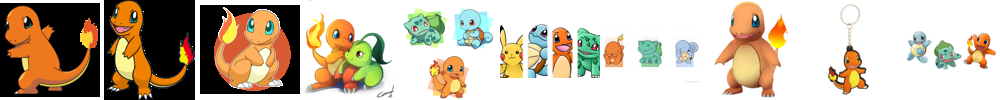

In [ ]:
show_image_from_directory('/content/charmander_test')

In [ ]:
Self_Extraction(model, '/content/charmander_test', 'Charmander')

1번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99999523
부분 이미지에 대한 최고 예측:  Charmander 0.9999801

2번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99999774
부분 이미지에 대한 최고 예측:  Charmander 0.9999988
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999237
부분 이미지에 대한 최고 예측:  Charmander 0.99631125

4번째 이미지
전체 이미지에 대한 예측:  Charmander 0.999385
부분 이미지에 대한 최고 예측:  Charmander 0.9999527
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Charmander 0.62162733
부분 이미지에 대한 최고 예측:  Charmander 0.9946866
새 이미지 생성

6번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.8798504
부분 이미지에 대한 최고 예측:  Charmander 0.9970149
새 이미지 생성

7번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.5880406
부분 이미지에 대한 최고 예측:  Charmander 0.52601576
새 이미지 생성

8번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999765
부분 이미지에 대한 최고 예측:  Charmander 0.9999496

9번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9993905
부분 이미지에 대한 최고 예측:  Charmander 0.9991079

10번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.59565103
부분 이미지에 대한 최고 예측:  Charmander 0.9839934
새 이미지 생성

--- Self Extraction Done ---


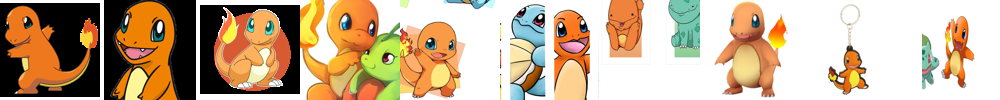

In [ ]:
show_image_from_directory('/content/charmander_test')

--- Self Extraction Done ---


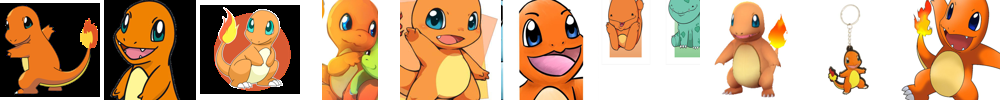

In [ ]:
Self_Extraction(model, '/content/charmander_test', 'Charmander', verbose=False)
show_image_from_directory('/content/charmander_test')

--- Self Extraction Done ---


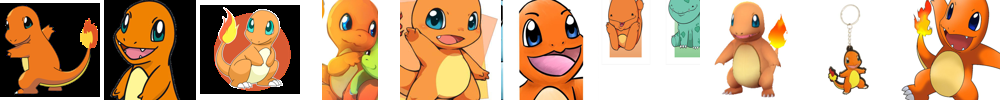

In [ ]:
Self_Extraction(model, '/content/charmander_test', 'Charmander', verbose=False)
show_image_from_directory('/content/charmander_test')

7번째 이미지를 제외하고, 모두 파이리의 모습으로 수렴한 것을 확인할 수 있다.

# 알고리즘 전후 차이 실험

모든 포켓몬에 대해 훈련, 테스트(15%) 이미지를 가지고 데이터셋을 생성하여 CNN 모델을 훈련한다. 

이후 Self Extraction 알고리즘을 데이터셋에 적용한 후, 초기화 된 CNN 모델을 훈련하여 모델 성능에 차이가 있는지 확인한다.

## 적용 전

적용 전 모델 실험은 전이학습 파일에 자세히 구현되어 있다.

여기서는 훈련된 모델을 불러와서 성능만 확인한다.

In [4]:
def model_train(model, data_loader, criterion, optimizer, device, scheduler=None):
    # 훈련모드(Gradient 업데이트)
    model.train()
    # loss와 accuracy 계산을 위한 변수.
    running_loss = 0
    corr = 0

    # mini-batch 
    for img, lbl in tqdm(data_loader):
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, lbl)
        loss.backward()
        optimizer.step()
        _, pred = output.max(dim=1) # max index를 반환
        corr += pred.eq(lbl).sum().item()  # 정확히 맞춘 경우 계산. 
        
        # loss 값은 1개 배치의 평균 loss, img.size(0)은 batch size
        # loss  * img.size(0)  -> 1개 배치의 전체 loss
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출
        running_loss += loss.item() * img.size(0)
        
    scheduler.step() 
    accuracy = corr / len(data_loader.dataset) # 평균 정확도
    loss = running_loss / len(data_loader.dataset) # 평균 loss
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
 
    return loss, accuracy

def model_evaluate(model, data_loader, criterion, device):
    # 평가모드
    model.eval()
    with torch.no_grad(): # Gradient 업데이트 방지
        running_loss = 0
        corr = 0
        
        # 배치별 evaluation
        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)   
            output = model(img)
            _, pred = output.max(dim=1) # max index를 반환
            corr += torch.sum(pred.eq(lbl)).item() # 정확히 맞춘 경우 계산. 
            
            # loss 값은 1개 배치의 평균 loss, img.size(0)은 batch size
            # loss  * img.size(0)  -> 1개 배치의 전체 loss
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출
            running_loss += criterion(output, lbl).item() * img.size(0)
        accuracy = corr / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(accuracy)       

        return loss, accuracy
    



In [5]:
# early stopping 
# patience 동안 delta값 만큼 loss가 개선되지 않으면 훈련종료 

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [6]:
# 불러온 pretrained 모델의 classifier 교체
# 나머지 레이어의 가중치 freezing
def change_classifier(model):
    
    for param in model.parameters():
        param.requires_grad = False    
    try:
        print('==========before change=========\n', model.fc)
        fc_in_features = model.fc.in_features
        model.fc = torch.nn.Sequential(
            nn.Dropout(0.5, inplace=True), 
            nn.Linear(in_features=fc_in_features, out_features=class_num))   
        print('\n=========after change==========\n', model.fc)        
    except:       
        print('==========before change=========\n', model.classifier)
        fc_in_features = model.classifier[1].in_features
        model.classifier = torch.nn.Sequential(
            nn.Dropout(0.5, inplace=True), 
            nn.Linear(in_features=fc_in_features, out_features=class_num))
        print('\n=========after change==========\n', model.classifier)    
    summary(model, (3,224,224), device ='cpu')
    return model

In [8]:
# local에 저장된 이미지들로 train dataset구성
# 여러 데이터 증강기법 적용
train_dataset = ImageFolder(root="Pokemon_1stGen/train",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.RandomCrop(216),
#                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#                           transforms.RandomRotation(degrees=(-20, 20), interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
                          transforms.RandomHorizontalFlip(0.8),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6242275, 0.6191041, 0.5806922), (0.2508186, 0.24027368, 0.24968527))
                      ]))

# local에 저장된 이미지들로 test dataset구성
test_dataset = ImageFolder(root="Pokemon_1stGen/test",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6172296, 0.6139809, 0.57699025), (0.2497807, 0.23995584, 0.24963577))
                      ]))

In [9]:
# train, test Data Loader 생성 
batch_size = 16
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=False,)

# class개수 확인
class_num = len(test_dataset.classes)
class_num

149

In [10]:
def train_set(model, lr=0.00007, patience=8):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    learning_rate = lr
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)
    es = EarlyStopping(patience=patience, delta=0, mode='max', verbose=True)
    print(device)
    return model, criterion, optimizer, scheduler, es, device

In [15]:
history = {'train_loss' : [], 'val_loss': [],
            'train_accuracy' :[], 'val_accuracy':[]}

# EfficientNet V2_S pretrained 모델 불러오기 
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_loaded =torchvision.models.efficientnet_v2_s(weights=weights)
model= change_classifier(model_loaded)

==========before change=========
 Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

=========after change==========
 Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=149, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
    

In [13]:
# 학습된 가중치 가져와서 평가
model.load_state_dict(torch.load('BestModel_effib_v2_s_2.pth'))
model, criterion, optimizer, scheduler, es, device = train_set(model)
final_loss, final_acc = model_evaluate(model, test_loader, criterion, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}') 

==========before change=========
 Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

=========after change==========
 Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=149, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
    

cuda
evaluation loss: 0.41782, evaluation accuracy: 0.89187


### 알고리즘 전 정확도 89.1%

## 알고리즘 적용 후 (1회)

In [40]:
# self extraction 알고리즘을 위한 알고리즘 적용 전 학습 모델 불러오기
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_loaded =torchvision.models.efficientnet_v2_s(weights=weights)
model= change_classifier(model_loaded)
model.load_state_dict(torch.load('BestModel_effib_v2_s_2.pth'))
model.to(device)

==========before change=========
 Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

=========after change==========
 Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=149, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
    

In [42]:
# 전체 이미지에 대해서 self extraction 알고리즘 수행 
# count는 새로 저장된 이미지의 수
count = 0
for label in test_dataset.classes:
    count += Self_Extraction(model, f'Pokemon_1stGen/train/{label}', label)
print('새로 저장된 이미지 수:', count)

1번째 이미지
전체 이미지에 대한 예측:  Abra 0.9908393
Pass

2번째 이미지
전체 이미지에 대한 예측:  Abra 0.95418125
Pass

3번째 이미지
전체 이미지에 대한 예측:  Abra 0.98885477
Pass

4번째 이미지
전체 이미지에 대한 예측:  Abra 0.9933982
Pass

5번째 이미지
전체 이미지에 대한 예측:  Abra 0.9839969
Pass

6번째 이미지
전체 이미지에 대한 예측:  Abra 0.9647259
Pass

7번째 이미지
전체 이미지에 대한 예측:  Abra 0.9904619
Pass

8번째 이미지
전체 이미지에 대한 예측:  Abra 0.9851274
Pass

9번째 이미지
전체 이미지에 대한 예측:  Abra 0.9906148
Pass

10번째 이미지
전체 이미지에 대한 예측:  Abra 0.93719727
부분 이미지에 대한 최고 예측:  Abra 0.9769021
새 이미지 생성

11번째 이미지
전체 이미지에 대한 예측:  Abra 0.9580014
Pass

12번째 이미지
전체 이미지에 대한 예측:  Abra 0.9812562
Pass

13번째 이미지
전체 이미지에 대한 예측:  Abra 0.98942786
Pass

14번째 이미지
전체 이미지에 대한 예측:  Abra 0.98268706
Pass

15번째 이미지
전체 이미지에 대한 예측:  Abra 0.98469526
Pass

16번째 이미지
전체 이미지에 대한 예측:  Abra 0.916689
부분 이미지에 대한 최고 예측:  Abra 0.9827874
새 이미지 생성

17번째 이미지
전체 이미지에 대한 예측:  Abra 0.95861226
Pass

18번째 이미지
전체 이미지에 대한 예측:  Abra 0.9834372
Pass

19번째 이미지
전체 이미지에 대한 예측:  Abra 0.99645054
Pass

20번째 이미지
전체 이미지에 대한 예측:  Abra 0.99248976
Pass

21번째 

부분 이미지에 대한 최고 예측:  Alakazam 0.9360211
새 이미지 생성

27번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.8661906
부분 이미지에 대한 최고 예측:  Alakazam 0.9522272
새 이미지 생성

28번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.8750308
부분 이미지에 대한 최고 예측:  Alakazam 0.9156805
새 이미지 생성

29번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.8186185
부분 이미지에 대한 최고 예측:  Alakazam 0.8920029
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.793769
부분 이미지에 대한 최고 예측:  Alakazam 0.9555344
새 이미지 생성

31번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.90889096
부분 이미지에 대한 최고 예측:  Alakazam 0.86186725

32번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.9621912
Pass

33번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.9190213
부분 이미지에 대한 최고 예측:  Alakazam 0.95767295
새 이미지 생성

34번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.86702895
부분 이미지에 대한 최고 예측:  Alakazam 0.94143325
새 이미지 생성

35번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.95263773
Pass

36번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.8702722
부분 이미지에 대한 최고 예측:  Alakazam 0.93484527
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Alakazam 0.69983834
부분 이미지에 대한 최고 예측:  Alakazam 0.857246
새 이미지 생성

38번째 이미지
전체 이미지에 대한 예측:  Al

부분 이미지에 대한 최고 예측:  Arcanine 0.9634209
새 이미지 생성

47번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.8844531
부분 이미지에 대한 최고 예측:  Arcanine 0.8948508
새 이미지 생성

48번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.88518107
부분 이미지에 대한 최고 예측:  Arcanine 0.9261377
새 이미지 생성

49번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.91979414
부분 이미지에 대한 최고 예측:  Arcanine 0.9429053
새 이미지 생성

50번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.8538405
부분 이미지에 대한 최고 예측:  Arcanine 0.77828246

51번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.86795723
부분 이미지에 대한 최고 예측:  Arcanine 0.911503
새 이미지 생성

52번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.9085237
부분 이미지에 대한 최고 예측:  Arcanine 0.9426839
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Articuno 0.98219925
Pass

2번째 이미지
전체 이미지에 대한 예측:  Articuno 0.9873247
Pass

3번째 이미지
전체 이미지에 대한 예측:  Articuno 0.9701799
Pass

4번째 이미지
전체 이미지에 대한 예측:  Articuno 0.9465501
부분 이미지에 대한 최고 예측:  Articuno 0.9668037
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Articuno 0.9523571
Pass

6번째 이미지
전체 이미지에 대한 예측:  Articuno 0.9725586
Pass

7번째 이미지
전체 이미지에 대한 예측:  Articuno 0.97289

11번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9960205
Pass

12번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9969025
Pass

13번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.99198747
Pass

14번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9970771
Pass

15번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9978544
Pass

16번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9922043
Pass

17번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.99797755
Pass

18번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.983993
Pass

19번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9940044
Pass

20번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9936475
Pass

21번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9959313
Pass

22번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.99724364
Pass

23번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9976179
Pass

24번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9956435
Pass

25번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9990771
Pass

26번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.99701357
Pass

27번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9761445
Pass

28번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9953786
Pass

29번째 이미지
전체 이미지에 대한 예측:  Blastoise 0.9965821
Pass

30번째 이미지
전체 이미지에 대한 예측:  Bla

120번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.99433374
Pass

121번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.99302024
Pass

122번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9961681
Pass

123번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.99069476
Pass

124번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9958616
Pass

125번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9853129
Pass

126번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9954248
Pass

127번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9942068
Pass

128번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.992789
Pass

129번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9790773
Pass

130번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9983462
Pass

131번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.97201085
Pass

132번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.99513584
Pass

133번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.71528625
부분 이미지에 대한 최고 예측:  Bulbasaur 0.9776123
새 이미지 생성

134번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9903211
Pass

135번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.98978883
Pass

136번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.97973275
Pass

137번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.9739623
Pass

138번째 이미지
전체 이미

20번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98976713
Pass

21번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9791986
Pass

22번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98986804
Pass

23번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98683316
Pass

24번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98932004
Pass

25번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.964796
Pass

26번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98275936
Pass

27번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.96891284
Pass

28번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98686546
Pass

29번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.7612442
부분 이미지에 대한 최고 예측:  Butterfree 0.99080336
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9738699
Pass

31번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9391846
부분 이미지에 대한 최고 예측:  Butterfree 0.99031514
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.99140364
Pass

33번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.98339313
Pass

34번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9887765
Pass

35번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9821206
Pass

36번째 이미지
전체 이미지에 대한 예측:  Butterfree 0.9874358
Pass

37번째 이미지
전체 이미지에 대

부분 이미지에 대한 최고 예측:  Charizard 0.99272174
새 이미지 생성

23번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9788159
Pass

24번째 이미지
전체 이미지에 대한 예측:  Charizard 0.99210596
Pass

25번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9401197
부분 이미지에 대한 최고 예측:  Charizard 0.98968595
새 이미지 생성

26번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9150313
부분 이미지에 대한 최고 예측:  Charizard 0.9941486
새 이미지 생성

27번째 이미지
전체 이미지에 대한 예측:  Charizard 0.98322475
Pass

28번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9729633
Pass

29번째 이미지
전체 이미지에 대한 예측:  Charizard 0.96579397
Pass

30번째 이미지
전체 이미지에 대한 예측:  Charizard 0.7817975
부분 이미지에 대한 최고 예측:  Charizard 0.8313163
새 이미지 생성

31번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9738864
Pass

32번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9858649
Pass

33번째 이미지
전체 이미지에 대한 예측:  Charizard 0.883865
부분 이미지에 대한 최고 예측:  Charizard 0.99296266
새 이미지 생성

34번째 이미지
전체 이미지에 대한 예측:  Charizard 0.97230625
Pass

35번째 이미지
전체 이미지에 대한 예측:  Charizard 0.9915753
Pass

36번째 이미지
전체 이미지에 대한 예측:  Charizard 0.98720133
Pass

37번째 이미지
전체 이미지에 대한 예측:  Charizard 0.8574774
부분 이미지에 대한 최고

129번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9932126
Pass

130번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9873403
Pass

131번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9211141
부분 이미지에 대한 최고 예측:  Charmander 0.86955935

132번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99191463
Pass

133번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9934248
Pass

134번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99004984
Pass

135번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99507385
Pass

136번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9005212
부분 이미지에 대한 최고 예측:  Charmander 0.98882806
새 이미지 생성

137번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99564123
Pass

138번째 이미지
전체 이미지에 대한 예측:  Charmander 0.5402994
부분 이미지에 대한 최고 예측:  Charmander 0.995906
새 이미지 생성

139번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9882505
Pass

140번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9946353
Pass

141번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9895348
Pass

142번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99195546
Pass

143번째 이미지
전체 이미지에 대한 예측:  Charmander 0.98849803
Pass

144번째 이미지
전체 이미지에 대한 예측:  Charmander 0.973917
Pass

145번째 이미지
전체 이미지에 대한 예측

부분 이미지에 대한 최고 예측:  Charmeleon 0.9681805
새 이미지 생성

27번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9604968
Pass

28번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.967607
Pass

29번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9871437
Pass

30번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9922327
Pass

31번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.99313426
Pass

32번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9969484
Pass

33번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.99336857
Pass

34번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.92779076
부분 이미지에 대한 최고 예측:  Charmeleon 0.9897826
새 이미지 생성

35번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.991126
Pass

36번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9830141
Pass

37번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9845674
Pass

38번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9924331
Pass

39번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.97612303
Pass

40번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.99334115
Pass

41번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9952354
Pass

42번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.99536586
Pass

43번째 이미지
전체 이미지에 대한 예측:  Charmeleon 0.9924281
Pass

44번째 이미지
전체 이미지에 대

11번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.99118304
Pass

12번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.96128774
Pass

13번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.98204136
Pass

14번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9849444
Pass

15번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9900766
Pass

16번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.99584514
Pass

17번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9820733
Pass

18번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.99034774
Pass

19번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9853479
Pass

20번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9614567
Pass

21번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9881451
Pass

22번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9763149
Pass

23번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9874588
Pass

24번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.99292034
Pass

25번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.97051406
Pass

26번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.97682685
Pass

27번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.99097836
Pass

28번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9850153
Pass

29번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.9699453
Pass

30번째 이미지
전체 이미지에 대한 예측:  Cloyster 0.98050

부분 이미지에 대한 최고 예측:  Dewgong 0.9543039
새 이미지 생성

44번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9441205
부분 이미지에 대한 최고 예측:  Dewgong 0.97962064
새 이미지 생성

45번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9525364
Pass

46번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.96769834
Pass

47번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.93467313
부분 이미지에 대한 최고 예측:  Dewgong 0.9765177
새 이미지 생성

48번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.88725543
부분 이미지에 대한 최고 예측:  Dewgong 0.96001464
새 이미지 생성

49번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9806698
Pass

50번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.8972736
부분 이미지에 대한 최고 예측:  Dewgong 0.97439826
새 이미지 생성

51번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9518197
Pass

52번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.98586303
Pass

53번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.98965657
Pass

54번째 이미지
전체 이미지에 대한 예측:  Seel 0.4631855
부분 이미지에 대한 최고 예측:  Dewgong 0.94956887
새 이미지 생성

55번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9373818
부분 이미지에 대한 최고 예측:  Dewgong 0.9674769
새 이미지 생성

56번째 이미지
전체 이미지에 대한 예측:  Dewgong 0.9265252
부분 이미지에 대한 최고 예측:  Dewgong 0.99183613
새 이미지 생성

57번째 이미지
전체 이미지에 대한 예측

부분 이미지에 대한 최고 예측:  Dodrio 0.9805124
새 이미지 생성

26번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.9693773
Pass

27번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.97848916
Pass

28번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.95581293
Pass

29번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.9719862
Pass

30번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.95119673
Pass

31번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.93920296
부분 이미지에 대한 최고 예측:  Dodrio 0.96938735
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.96986276
Pass

33번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.96473664
Pass

34번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.98758566
Pass

35번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.8874631
부분 이미지에 대한 최고 예측:  Dodrio 0.9933735
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.9182244
부분 이미지에 대한 최고 예측:  Dodrio 0.9859364
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.9916459
Pass

38번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.98339313
Pass

39번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.87788564
부분 이미지에 대한 최고 예측:  Dodrio 0.9823025
새 이미지 생성

40번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.9958425
Pass

41번째 이미지
전체 이미지에 대한 예측:  Dodrio 0.975465
Pass

42번째 이미지
전체 이미지에 

부분 이미지에 대한 최고 예측:  Dragonite 0.9258094
새 이미지 생성

2번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.93392867
부분 이미지에 대한 최고 예측:  Dragonite 0.96641237
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.97019994
Pass

4번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.97072756
Pass

5번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.8617114
부분 이미지에 대한 최고 예측:  Dragonite 0.9742776
새 이미지 생성

6번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.8822688
부분 이미지에 대한 최고 예측:  Dragonite 0.93995905
새 이미지 생성

7번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.9229894
부분 이미지에 대한 최고 예측:  Dragonite 0.94001794
새 이미지 생성

8번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.9602618
Pass

9번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.8350538
부분 이미지에 대한 최고 예측:  Dragonite 0.9425089
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.90424055
부분 이미지에 대한 최고 예측:  Dragonite 0.89598495

11번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.8419182
부분 이미지에 대한 최고 예측:  Dragonite 0.96190166
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.95856345
Pass

13번째 이미지
전체 이미지에 대한 예측:  Dragonite 0.91292566
부분 이미지에 대한 최고 예측:  Dragonite 0.9738864
새 이미지 생성

1

82번째 이미지
전체 이미지에 대한 예측:  Dratini 0.98564756
Pass

83번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9838127
Pass

84번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9864053
Pass

85번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9917841
Pass

86번째 이미지
전체 이미지에 대한 예측:  Dratini 0.99198675
Pass

87번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9898762
Pass

88번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9950531
Pass

89번째 이미지
전체 이미지에 대한 예측:  Dratini 0.99503726
Pass

90번째 이미지
전체 이미지에 대한 예측:  Dratini 0.98602563
Pass

91번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9949032
Pass

92번째 이미지
전체 이미지에 대한 예측:  Dratini 0.9925721
Pass

93번째 이미지
전체 이미지에 대한 예측:  Dratini 0.99324894
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9783587
Pass

2번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9987362
Pass

3번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9933229
Pass

4번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9901916
Pass

5번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9709664
Pass

6번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9723149
Pass

7번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.98247266
Pass

8번째 이미지
전체 이미지에 대한 예측:  Drowzee 0.9910750

18번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9967236
Pass

19번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9934175
Pass

20번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9936367
Pass

21번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9915114
Pass

22번째 이미지
전체 이미지에 대한 예측:  Ekans 0.98553956
Pass

23번째 이미지
전체 이미지에 대한 예측:  Ekans 0.99252254
Pass

24번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9767636
Pass

25번째 이미지
전체 이미지에 대한 예측:  Ekans 0.991265
Pass

26번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9915656
Pass

27번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9909863
Pass

28번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9437394
부분 이미지에 대한 최고 예측:  Ekans 0.9927651
새 이미지 생성

29번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9900912
Pass

30번째 이미지
전체 이미지에 대한 예측:  Ekans 0.98153174
Pass

31번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9871158
Pass

32번째 이미지
전체 이미지에 대한 예측:  Ekans 0.8259228
부분 이미지에 대한 최고 예측:  Ekans 0.82307005

33번째 이미지
전체 이미지에 대한 예측:  Ekans 0.98880786
Pass

34번째 이미지
전체 이미지에 대한 예측:  Ekans 0.98997176
Pass

35번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9985114
Pass

36번째 이미지
전체 이미지에 대한 예측:  Ekans 0.994842
Pass

37번째 이미지
전체 이미지에 대한 예측:  Ekans 0.9

21번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9926063
Pass

22번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98981035
Pass

23번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98451024
Pass

24번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9882731
Pass

25번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9858482
Pass

26번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9893484
Pass

27번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98805165
Pass

28번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9931772
Pass

29번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98909795
Pass

30번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.984089
Pass

31번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98623925
Pass

32번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9916345
Pass

33번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9935958
Pass

34번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98731625
Pass

35번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98680985
Pass

36번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.991714
Pass

37번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.965943
Pass

38번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.98143667
Pass

39번째 이미지
전체 이미지에 대한 예측:  Exeggcute 0.9864851
Pass

40번째 이미지
전체 이미지에 대한 예측:  E

15번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9825433
Pass

16번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9822673
Pass

17번째 이미지
전체 이미지에 대한 예측:  Fearow 0.985925
Pass

18번째 이미지
전체 이미지에 대한 예측:  Fearow 0.98896736
Pass

19번째 이미지
전체 이미지에 대한 예측:  Fearow 0.97613484
Pass

20번째 이미지
전체 이미지에 대한 예측:  Fearow 0.97299486
Pass

21번째 이미지
전체 이미지에 대한 예측:  Fearow 0.98501194
Pass

22번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9791422
Pass

23번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9896012
Pass

24번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9872285
Pass

25번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9858436
Pass

26번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9450558
부분 이미지에 대한 최고 예측:  Fearow 0.98002887
새 이미지 생성

27번째 이미지
전체 이미지에 대한 예측:  Fearow 0.98611605
Pass

28번째 이미지
전체 이미지에 대한 예측:  Fearow 0.99019706
Pass

29번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9943498
Pass

30번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9898516
Pass

31번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9849551
Pass

32번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9927741
Pass

33번째 이미지
전체 이미지에 대한 예측:  Fearow 0.98173136
Pass

34번째 이미지
전체 이미지에 대한 예측:  Fearow 0.9898511

16번째 이미지
전체 이미지에 대한 예측:  Gastly 0.95459235
Pass

17번째 이미지
전체 이미지에 대한 예측:  Gastly 0.98494554
Pass

18번째 이미지
전체 이미지에 대한 예측:  Gastly 0.99354315
Pass

19번째 이미지
전체 이미지에 대한 예측:  Gastly 0.9896019
Pass

20번째 이미지
전체 이미지에 대한 예측:  Gastly 0.99379903
Pass

21번째 이미지
전체 이미지에 대한 예측:  Gastly 0.9964217
Pass

22번째 이미지
전체 이미지에 대한 예측:  Gastly 0.9936939
Pass

23번째 이미지
전체 이미지에 대한 예측:  Gastly 0.98843956
Pass

24번째 이미지
전체 이미지에 대한 예측:  Gastly 0.98894715
Pass

25번째 이미지
전체 이미지에 대한 예측:  Gastly 0.987092
Pass

26번째 이미지
전체 이미지에 대한 예측:  Gastly 0.95122105
Pass

27번째 이미지
전체 이미지에 대한 예측:  Gastly 0.996427
Pass

28번째 이미지
전체 이미지에 대한 예측:  Gastly 0.98711014
Pass

29번째 이미지
전체 이미지에 대한 예측:  Gastly 0.99356353
Pass

30번째 이미지
전체 이미지에 대한 예측:  Gastly 0.9898864
Pass

31번째 이미지
전체 이미지에 대한 예측:  Gastly 0.911165
부분 이미지에 대한 최고 예측:  Gastly 0.9842897
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Gastly 0.97743386
Pass

33번째 이미지
전체 이미지에 대한 예측:  Gastly 0.95390713
Pass

34번째 이미지
전체 이미지에 대한 예측:  Gastly 0.9906123
Pass

35번째 이미지
전체 이미지에 대한 예측:  Gastly 0.991809

부분 이미지에 대한 최고 예측:  Gloom 0.9247397
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Gloom 0.97754204
Pass

13번째 이미지
전체 이미지에 대한 예측:  Gloom 0.99511564
Pass

14번째 이미지
전체 이미지에 대한 예측:  Gloom 0.99388266
Pass

15번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9902146
Pass

16번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9811127
Pass

17번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9801033
Pass

18번째 이미지
전체 이미지에 대한 예측:  Gloom 0.99167085
Pass

19번째 이미지
전체 이미지에 대한 예측:  Gloom 0.98954517
Pass

20번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9888967
Pass

21번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9811381
Pass

22번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9868146
Pass

23번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9954379
Pass

24번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9437276
부분 이미지에 대한 최고 예측:  Gloom 0.9957027
새 이미지 생성

25번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9829131
Pass

26번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9913244
Pass

27번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9986255
Pass

28번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9903538
Pass

29번째 이미지
전체 이미지에 대한 예측:  Gloom 0.99164283
Pass

30번째 이미지
전체 이미지에 대한 예측:  Gloom 0.9924204
Pass

31번째 이미지
전체 이미지에 

2번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9841456
Pass

3번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9964232
Pass

4번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9947807
Pass

5번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9858883
Pass

6번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9897915
Pass

7번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9871351
Pass

8번째 이미지
전체 이미지에 대한 예측:  Golduck 0.99687284
Pass

9번째 이미지
전체 이미지에 대한 예측:  Golduck 0.992413
Pass

10번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9905419
Pass

11번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9927846
Pass

12번째 이미지
전체 이미지에 대한 예측:  Golduck 0.99163437
Pass

13번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9879247
Pass

14번째 이미지
전체 이미지에 대한 예측:  Golduck 0.98947704
Pass

15번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9945332
Pass

16번째 이미지
전체 이미지에 대한 예측:  Golduck 0.99849033
Pass

17번째 이미지
전체 이미지에 대한 예측:  Golduck 0.98477453
Pass

18번째 이미지
전체 이미지에 대한 예측:  Golduck 0.98429745
Pass

19번째 이미지
전체 이미지에 대한 예측:  Golduck 0.9955012
Pass

20번째 이미지
전체 이미지에 대한 예측:  Golduck 0.98691535
Pass

21번째 이미지
전체 이미지에 대한 예측:  Golduck 0.99475044
Pass

22번째 이미지
전체 이미지에 대한 예

28번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9839049
Pass

29번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9904951
Pass

30번째 이미지
전체 이미지에 대한 예측:  Graveler 0.98858833
Pass

31번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9104621
부분 이미지에 대한 최고 예측:  Graveler 0.98280185
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9910835
Pass

33번째 이미지
전체 이미지에 대한 예측:  Graveler 0.98907846
Pass

34번째 이미지
전체 이미지에 대한 예측:  Graveler 0.963744
Pass

35번째 이미지
전체 이미지에 대한 예측:  Graveler 0.98837715
Pass

36번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9743726
Pass

37번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9921818
Pass

38번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9865953
Pass

39번째 이미지
전체 이미지에 대한 예측:  Graveler 0.99482286
Pass

40번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9838743
Pass

41번째 이미지
전체 이미지에 대한 예측:  Graveler 0.99082947
Pass

42번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9852197
Pass

43번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9778592
Pass

44번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9789918
Pass

45번째 이미지
전체 이미지에 대한 예측:  Graveler 0.9896125
Pass

46번째 이미지
전체 이미지에 대한 예측:  Graveler 0.96218944
Pass

47

부분 이미지에 대한 최고 예측:  Growlithe 0.9772619
새 이미지 생성

33번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.67993766
부분 이미지에 대한 최고 예측:  Growlithe 0.7115262
새 이미지 생성

34번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.82945627
부분 이미지에 대한 최고 예측:  Growlithe 0.9516549
새 이미지 생성

35번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.7376757
부분 이미지에 대한 최고 예측:  Growlithe 0.985989
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.8517138
부분 이미지에 대한 최고 예측:  Growlithe 0.98263377
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Arcanine 0.8228868
부분 이미지에 대한 최고 예측:  Growlithe 0.6498536
새 이미지 생성

38번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.9719595
Pass

39번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.9377761
부분 이미지에 대한 최고 예측:  Growlithe 0.98527145
새 이미지 생성

40번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.9198602
부분 이미지에 대한 최고 예측:  Growlithe 0.9803387
새 이미지 생성

41번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.8211779
부분 이미지에 대한 최고 예측:  Growlithe 0.9764696
새 이미지 생성

42번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.95026845
Pass

43번째 이미지
전체 이미지에 대한 예측:  Growlithe 0.90565026
부분 이미지에 대한 최고 예측:  Growlithe 0.9795492
새 이미지 생성



3번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9646094
Pass

4번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9757798
Pass

5번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9235139
부분 이미지에 대한 최고 예측:  Hitmonchan 0.99775034
새 이미지 생성

6번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.990263
Pass

7번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9931906
Pass

8번째 이미지
전체 이미지에 대한 예측:  Hitmonlee 0.6855388
부분 이미지에 대한 최고 예측:  Hitmonchan 0.98163456
새 이미지 생성

9번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9838321
Pass

10번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9402052
부분 이미지에 대한 최고 예측:  Hitmonchan 0.99414283
새 이미지 생성

11번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.93993753
부분 이미지에 대한 최고 예측:  Hitmonchan 0.99756575
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.92061925
부분 이미지에 대한 최고 예측:  Hitmonchan 0.9818378
새 이미지 생성

13번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9432458
부분 이미지에 대한 최고 예측:  Hitmonchan 0.9961598
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.91969854
부분 이미지에 대한 최고 예측:  Hitmonchan 0.99521697
새 이미지 생성

15번째 이미지
전체 이미지에 대한 예측:  Hitmonchan 0.9329905
부분 이미지에 대한 최고 예측:  Hitm

부분 이미지에 대한 최고 예측:  Horsea 0.9794336
새 이미지 생성

26번째 이미지
전체 이미지에 대한 예측:  Horsea 0.98288226
Pass

27번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9869213
Pass

28번째 이미지
전체 이미지에 대한 예측:  Horsea 0.99552685
Pass

29번째 이미지
전체 이미지에 대한 예측:  Horsea 0.98253757
Pass

30번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9881165
Pass

31번째 이미지
전체 이미지에 대한 예측:  Seadra 0.64852613
부분 이미지에 대한 최고 예측:  Horsea 0.9493071
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9954223
Pass

33번째 이미지
전체 이미지에 대한 예측:  Horsea 0.977119
Pass

34번째 이미지
전체 이미지에 대한 예측:  Horsea 0.99560404
Pass

35번째 이미지
전체 이미지에 대한 예측:  Horsea 0.98613644
Pass

36번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9969482
Pass

37번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9964348
Pass

38번째 이미지
전체 이미지에 대한 예측:  Horsea 0.98921436
Pass

39번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9613482
Pass

40번째 이미지
전체 이미지에 대한 예측:  Seadra 0.860174
올바른 부분 이미지 부재

41번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9969741
Pass

42번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9828934
Pass

43번째 이미지
전체 이미지에 대한 예측:  Horsea 0.9588793
Pass

44번째 이미지
전체 이미지에 대한 예측:  Horsea 0.99

부분 이미지에 대한 최고 예측:  Jigglypuff 0.99517536
새 이미지 생성

33번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.97034484
Pass

34번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9945803
Pass

35번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.8921719
부분 이미지에 대한 최고 예측:  Jigglypuff 0.9565614
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.98904234
Pass

37번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9955348
Pass

38번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9943463
Pass

39번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.98228675
Pass

40번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.991285
Pass

41번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9903779
Pass

42번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9919309
Pass

43번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9854698
Pass

44번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9927793
Pass

45번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9939135
Pass

46번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9948992
Pass

47번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9844994
Pass

48번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9821253
Pass

49번째 이미지
전체 이미지에 대한 예측:  Jigglypuff 0.9911957
Pass

50번째 이미지
전체 이미지에 대한

부분 이미지에 대한 최고 예측:  Kabuto 0.9710468
새 이미지 생성

25번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.877461
부분 이미지에 대한 최고 예측:  Kabuto 0.9064584
새 이미지 생성

26번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.9679091
Pass

27번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.90848404
부분 이미지에 대한 최고 예측:  Kabuto 0.967518
새 이미지 생성

28번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.7750178
부분 이미지에 대한 최고 예측:  Kabuto 0.8743489
새 이미지 생성

29번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.9724177
Pass

30번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.9739086
Pass

31번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.791487
부분 이미지에 대한 최고 예측:  Kabuto 0.97595984
새 이미지 생성

32번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.79361856
부분 이미지에 대한 최고 예측:  Kabuto 0.9491006
새 이미지 생성

33번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.97049767
Pass

34번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.75680006
부분 이미지에 대한 최고 예측:  Kabuto 0.8750008
새 이미지 생성

35번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.6793658
부분 이미지에 대한 최고 예측:  Kabuto 0.8973916
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.9284904
부분 이미지에 대한 최고 예측:  Kabuto 0.9419613
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Kabuto 0.9493787
부분 이미지에 대한 최고 

부분 이미지에 대한 최고 예측:  Kadabra 0.9787451
새 이미지 생성

52번째 이미지
전체 이미지에 대한 예측:  Kadabra 0.74690557
부분 이미지에 대한 최고 예측:  Kadabra 0.9261978
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9883886
Pass

2번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.986938
Pass

3번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.97945994
Pass

4번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.98926836
Pass

5번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.990391
Pass

6번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9907052
Pass

7번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9817677
Pass

8번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9852512
Pass

9번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.99158454
Pass

10번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.98622894
Pass

11번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.99160856
Pass

12번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9860692
Pass

13번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9947665
Pass

14번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.96815366
Pass

15번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.98569936
Pass

16번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9873252
Pass

17번째 이미지
전체 이미지에 대한 예측:  Kakuna 0.9920442
Pass

18번째 이미지
전체 이미지에 대한 예

부분 이미지에 대한 최고 예측:  Kingler 0.9701876
새 이미지 생성

29번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9842911
Pass

30번째 이미지
전체 이미지에 대한 예측:  Kingler 0.99029726
Pass

31번째 이미지
전체 이미지에 대한 예측:  Kingler 0.98634934
Pass

32번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9807325
Pass

33번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9715603
Pass

34번째 이미지
전체 이미지에 대한 예측:  Kingler 0.95235604
Pass

35번째 이미지
전체 이미지에 대한 예측:  Krabby 0.7767222
부분 이미지에 대한 최고 예측:  Kingler 0.9414729
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9824124
Pass

37번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9874194
Pass

38번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9591367
Pass

39번째 이미지
전체 이미지에 대한 예측:  Kingler 0.8949598
부분 이미지에 대한 최고 예측:  Kingler 0.9886564
새 이미지 생성

40번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9872635
Pass

41번째 이미지
전체 이미지에 대한 예측:  Kingler 0.82715875
부분 이미지에 대한 최고 예측:  Kingler 0.94267774
새 이미지 생성

42번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9328168
부분 이미지에 대한 최고 예측:  Kingler 0.9372805
새 이미지 생성

43번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9752289
Pass

44번째 이미지
전체 이미지에 대한 예측:  Kingler 0.9300022
부분 이미지에

10번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9911398
Pass

11번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9871106
Pass

12번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9645789
Pass

13번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9929259
Pass

14번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9910938
Pass

15번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9915776
Pass

16번째 이미지
전체 이미지에 대한 예측:  Lapras 0.97471184
Pass

17번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9927719
Pass

18번째 이미지
전체 이미지에 대한 예측:  Lapras 0.98809856
Pass

19번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9908133
Pass

20번째 이미지
전체 이미지에 대한 예측:  Lapras 0.98770916
Pass

21번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9870854
Pass

22번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9940865
Pass

23번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9790627
Pass

24번째 이미지
전체 이미지에 대한 예측:  Lapras 0.99584514
Pass

25번째 이미지
전체 이미지에 대한 예측:  Lapras 0.99412066
Pass

26번째 이미지
전체 이미지에 대한 예측:  Lapras 0.96453357
Pass

27번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9919057
Pass

28번째 이미지
전체 이미지에 대한 예측:  Lapras 0.99238294
Pass

29번째 이미지
전체 이미지에 대한 예측:  Lapras 0.9769397
Pass

30번째 이미지
전체 이미지에 대한 예측:  Lapras 0

부분 이미지에 대한 최고 예측:  Machamp 0.96767163
새 이미지 생성

41번째 이미지
전체 이미지에 대한 예측:  Machamp 0.91355366
부분 이미지에 대한 최고 예측:  Machamp 0.93264633
새 이미지 생성

42번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9552215
Pass

43번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9421018
부분 이미지에 대한 최고 예측:  Machamp 0.98390746
새 이미지 생성

44번째 이미지
전체 이미지에 대한 예측:  Machamp 0.95646244
Pass

45번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9268791
부분 이미지에 대한 최고 예측:  Machamp 0.9481364
새 이미지 생성

46번째 이미지
전체 이미지에 대한 예측:  Machamp 0.96321416
Pass

47번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9539066
Pass

48번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9566312
Pass

49번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9116658
부분 이미지에 대한 최고 예측:  Machamp 0.96957517
새 이미지 생성

50번째 이미지
전체 이미지에 대한 예측:  Machamp 0.96221215
Pass

51번째 이미지
전체 이미지에 대한 예측:  Machamp 0.9144071
부분 이미지에 대한 최고 예측:  Machamp 0.97258943
새 이미지 생성

52번째 이미지
전체 이미지에 대한 예측:  Machoke 0.53125376
부분 이미지에 대한 최고 예측:  Machamp 0.8979046
새 이미지 생성

53번째 이미지
전체 이미지에 대한 예측:  Machamp 0.95982635
Pass

54번째 이미지
전체 이미지에 대한 예측:  Machamp 0.91391027
부분 이미지에 대한 최고 예

부분 이미지에 대한 최고 예측:  Magikarp 0.9564223
새 이미지 생성

27번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9431188
부분 이미지에 대한 최고 예측:  Magikarp 0.9971644
새 이미지 생성

28번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.970731
Pass

29번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.98509306
Pass

30번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.97896
Pass

31번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.97816306
Pass

32번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9960116
Pass

33번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9943433
Pass

34번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9936725
Pass

35번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9934642
Pass

36번째 이미지
전체 이미지에 대한 예측:  Gyarados 0.8210553
부분 이미지에 대한 최고 예측:  Magikarp 0.99256116
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.99712676
Pass

38번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.99051625
Pass

39번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.99478596
Pass

40번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9955922
Pass

41번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.92417186
부분 이미지에 대한 최고 예측:  Magikarp 0.977539
새 이미지 생성

42번째 이미지
전체 이미지에 대한 예측:  Magikarp 0.9972084
Pass

43번째 이미지
전체 이미지에 대한 예측:

29번째 이미지
전체 이미지에 대한 예측:  Magneton 0.8913215
부분 이미지에 대한 최고 예측:  Magneton 0.99307305
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Magneton 0.9753897
Pass

31번째 이미지
전체 이미지에 대한 예측:  Magneton 0.7111583
부분 이미지에 대한 최고 예측:  Magneton 0.31510162

32번째 이미지
전체 이미지에 대한 예측:  Magneton 0.96643525
Pass

33번째 이미지
전체 이미지에 대한 예측:  Magnemite 0.6746242
부분 이미지에 대한 최고 예측:  Magneton 0.9221656
새 이미지 생성

34번째 이미지
전체 이미지에 대한 예측:  Magneton 0.95023465
Pass

35번째 이미지
전체 이미지에 대한 예측:  Magneton 0.96649665
Pass

36번째 이미지
전체 이미지에 대한 예측:  Magneton 0.9673139
Pass

37번째 이미지
전체 이미지에 대한 예측:  Magneton 0.97410065
Pass

38번째 이미지
전체 이미지에 대한 예측:  Magneton 0.9711312
Pass

39번째 이미지
전체 이미지에 대한 예측:  Magneton 0.9720243
Pass

40번째 이미지
전체 이미지에 대한 예측:  Magneton 0.988741
Pass

41번째 이미지
전체 이미지에 대한 예측:  Magneton 0.95183593
Pass

42번째 이미지
전체 이미지에 대한 예측:  Magneton 0.9422155
부분 이미지에 대한 최고 예측:  Magneton 0.9784652
새 이미지 생성

43번째 이미지
전체 이미지에 대한 예측:  Magneton 0.6127551
부분 이미지에 대한 최고 예측:  Magneton 0.93998474
새 이미지 생성

44번째 이미지
전체 이미지에 대한 예측:  Magneton 0.97501

54번째 이미지
전체 이미지에 대한 예측:  Marowak 0.73202956
부분 이미지에 대한 최고 예측:  Marowak 0.83173794
새 이미지 생성

55번째 이미지
전체 이미지에 대한 예측:  Marowak 0.96684766
Pass

56번째 이미지
전체 이미지에 대한 예측:  Cubone 0.83077127
부분 이미지에 대한 최고 예측:  Marowak 0.9507189
새 이미지 생성

57번째 이미지
전체 이미지에 대한 예측:  Marowak 0.49238166
부분 이미지에 대한 최고 예측:  Marowak 0.85009134
새 이미지 생성

58번째 이미지
전체 이미지에 대한 예측:  Cubone 0.52156705
부분 이미지에 대한 최고 예측:  Marowak 0.9851516
새 이미지 생성

59번째 이미지
전체 이미지에 대한 예측:  Cubone 0.7935193
부분 이미지에 대한 최고 예측:  Marowak 0.6189568
새 이미지 생성

60번째 이미지
전체 이미지에 대한 예측:  Marowak 0.5212815
부분 이미지에 대한 최고 예측:  Marowak 0.9783106
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Meowth 0.9851409
Pass

2번째 이미지
전체 이미지에 대한 예측:  Meowth 0.8738016
부분 이미지에 대한 최고 예측:  Meowth 0.9942325
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Meowth 0.9799421
Pass

4번째 이미지
전체 이미지에 대한 예측:  Meowth 0.97878826
Pass

5번째 이미지
전체 이미지에 대한 예측:  Meowth 0.9759981
Pass

6번째 이미지
전체 이미지에 대한 예측:  Meowth 0.9882703
Pass

7번째 이미지
전체 이미지에 대한 예측:  Meowth 0.99084574
Pass

8번째 이미지

33번째 이미지
전체 이미지에 대한 예측:  Mew 0.99595946
Pass

34번째 이미지
전체 이미지에 대한 예측:  Mew 0.9964935
Pass

35번째 이미지
전체 이미지에 대한 예측:  Mew 0.99345547
Pass

36번째 이미지
전체 이미지에 대한 예측:  Mew 0.9717919
Pass

37번째 이미지
전체 이미지에 대한 예측:  Mew 0.9401179
부분 이미지에 대한 최고 예측:  Mew 0.9956873
새 이미지 생성

38번째 이미지
전체 이미지에 대한 예측:  Mew 0.9815244
Pass

39번째 이미지
전체 이미지에 대한 예측:  Mew 0.99568874
Pass

40번째 이미지
전체 이미지에 대한 예측:  Mew 0.9896007
Pass

41번째 이미지
전체 이미지에 대한 예측:  Mew 0.9947296
Pass

42번째 이미지
전체 이미지에 대한 예측:  Mew 0.99596137
Pass

43번째 이미지
전체 이미지에 대한 예측:  Mew 0.9928484
Pass

44번째 이미지
전체 이미지에 대한 예측:  Mew 0.9985821
Pass

45번째 이미지
전체 이미지에 대한 예측:  Mew 0.9929188
Pass

46번째 이미지
전체 이미지에 대한 예측:  Mew 0.98365504
Pass

47번째 이미지
전체 이미지에 대한 예측:  Mew 0.9876621
Pass

48번째 이미지
전체 이미지에 대한 예측:  Mew 0.9946291
Pass

49번째 이미지
전체 이미지에 대한 예측:  Mew 0.99128175
Pass

50번째 이미지
전체 이미지에 대한 예측:  Mew 0.99502075
Pass

51번째 이미지
전체 이미지에 대한 예측:  Mew 0.9910573
Pass

52번째 이미지
전체 이미지에 대한 예측:  Mew 0.99355996
Pass

53번째 이미지
전체 이미지에 대한 예측:  Mew 0.9960169
Pass

54번째 이미지
전

부분 이미지에 대한 최고 예측:  Mewtwo 0.961307
새 이미지 생성

144번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.98957413
Pass

145번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9926966
Pass

146번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9959188
Pass

147번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9868261
Pass

148번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9954717
Pass

149번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99151695
Pass

150번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9921828
Pass

151번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9293524
부분 이미지에 대한 최고 예측:  Mewtwo 0.99880934
새 이미지 생성

152번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99389476
Pass

153번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.98550445
Pass

154번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.981631
Pass

155번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9778646
Pass

156번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99125636
Pass

157번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99432003
Pass

158번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99415004
Pass

159번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.99237484
Pass

160번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.9834049
Pass

161번째 이미지
전체 이미지에 대한 예측:  Mewtwo 0.95408076
Pass

162번째 이미지
전체 이미지에 대한 예측:

43번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9888337
Pass

44번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9935051
Pass

45번째 이미지
전체 이미지에 대한 예측:  Moltres 0.99281317
Pass

46번째 이미지
전체 이미지에 대한 예측:  Moltres 0.99509263
Pass

47번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9974044
Pass

48번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9608048
Pass

49번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9891656
Pass

50번째 이미지
전체 이미지에 대한 예측:  Moltres 0.8938759
부분 이미지에 대한 최고 예측:  Moltres 0.9942782
새 이미지 생성

51번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9605335
Pass

52번째 이미지
전체 이미지에 대한 예측:  Moltres 0.99826753
Pass

53번째 이미지
전체 이미지에 대한 예측:  Moltres 0.9944411
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  MrMime 0.99768746
Pass

2번째 이미지
전체 이미지에 대한 예측:  MrMime 0.99242556
Pass

3번째 이미지
전체 이미지에 대한 예측:  MrMime 0.9773676
Pass

4번째 이미지
전체 이미지에 대한 예측:  MrMime 0.99641126
Pass

5번째 이미지
전체 이미지에 대한 예측:  MrMime 0.9963505
Pass

6번째 이미지
전체 이미지에 대한 예측:  MrMime 0.99257636
Pass

7번째 이미지
전체 이미지에 대한 예측:  MrMime 0.99505424
Pass

8번째 이미지
전체 이미지에 대한 예측:  MrMime 0.9952414
Pass

9번째 이미지

부분 이미지에 대한 최고 예측:  Nidoking 0.9620301
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9942304
Pass

15번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9367805
부분 이미지에 대한 최고 예측:  Nidoking 0.9925961
새 이미지 생성

16번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9923099
Pass

17번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9865363
Pass

18번째 이미지
전체 이미지에 대한 예측:  Nidoqueen 0.55613786
부분 이미지에 대한 최고 예측:  Nidoking 0.58564556
새 이미지 생성

19번째 이미지
전체 이미지에 대한 예측:  Nidorino 0.73029315
부분 이미지에 대한 최고 예측:  Nidoking 0.36417863
새 이미지 생성

20번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.97709334
Pass

21번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9902048
Pass

22번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9871157
Pass

23번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9777509
Pass

24번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9973985
Pass

25번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.99125344
Pass

26번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.99290985
Pass

27번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9894231
Pass

28번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.9925605
Pass

29번째 이미지
전체 이미지에 대한 예측:  Nidoking 0.98524874
Pass

30번째 이미지
전체 이미지에 

24번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.88030916
부분 이미지에 대한 최고 예측:  Nidorina 0.98259616
새 이미지 생성

25번째 이미지
전체 이미지에 대한 예측:  Nidoqueen 0.8405693
올바른 부분 이미지 부재

26번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.95393056
Pass

27번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.95113045
Pass

28번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9208876
부분 이미지에 대한 최고 예측:  Nidorina 0.9533574
새 이미지 생성

29번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9875951
Pass

30번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9909299
Pass

31번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9771419
Pass

32번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.96605074
Pass

33번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.8271847
부분 이미지에 대한 최고 예측:  Nidorina 0.9932949
새 이미지 생성

34번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.8887028
부분 이미지에 대한 최고 예측:  Nidorina 0.9835918
새 이미지 생성

35번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.992151
Pass

36번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9487846
부분 이미지에 대한 최고 예측:  Nidorina 0.99089855
새 이미지 생성

37번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.97346514
Pass

38번째 이미지
전체 이미지에 대한 예측:  Nidorina 0.9881341
Pass

39번째 이미지
전체 이미지에 대한 예측: 

7번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9958495
Pass

8번째 이미지
전체 이미지에 대한 예측:  Oddish 0.98383594
Pass

9번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99549073
Pass

10번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9879832
Pass

11번째 이미지
전체 이미지에 대한 예측:  Oddish 0.98856294
Pass

12번째 이미지
전체 이미지에 대한 예측:  Oddish 0.979965
Pass

13번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9943368
Pass

14번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99201125
Pass

15번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9863251
Pass

16번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9183452
부분 이미지에 대한 최고 예측:  Oddish 0.9932527
새 이미지 생성

17번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9952088
Pass

18번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9635022
Pass

19번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99410087
Pass

20번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99181306
Pass

21번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99318224
Pass

22번째 이미지
전체 이미지에 대한 예측:  Oddish 0.98805225
Pass

23번째 이미지
전체 이미지에 대한 예측:  Oddish 0.9837765
Pass

24번째 이미지
전체 이미지에 대한 예측:  Gloom 0.6642277
부분 이미지에 대한 최고 예측:  Oddish 0.4474755
새 이미지 생성

25번째 이미지
전체 이미지에 대한 예측:  Oddish 0.99371475
Pass

26번째

부분 이미지에 대한 최고 예측:  Onix 0.9829609
새 이미지 생성

2번째 이미지
전체 이미지에 대한 예측:  Onix 0.97210985
Pass

3번째 이미지
전체 이미지에 대한 예측:  Onix 0.980293
Pass

4번째 이미지
전체 이미지에 대한 예측:  Onix 0.9151957
부분 이미지에 대한 최고 예측:  Onix 0.9897114
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Onix 0.9829086
Pass

6번째 이미지
전체 이미지에 대한 예측:  Onix 0.97827715
Pass

7번째 이미지
전체 이미지에 대한 예측:  Onix 0.9606786
Pass

8번째 이미지
전체 이미지에 대한 예측:  Onix 0.9788118
Pass

9번째 이미지
전체 이미지에 대한 예측:  Onix 0.91654414
부분 이미지에 대한 최고 예측:  Onix 0.9891755
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Onix 0.9761772
Pass

11번째 이미지
전체 이미지에 대한 예측:  Onix 0.8677572
부분 이미지에 대한 최고 예측:  Onix 0.9812034
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Onix 0.99364436
Pass

13번째 이미지
전체 이미지에 대한 예측:  Onix 0.9480706
부분 이미지에 대한 최고 예측:  Onix 0.993255
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Onix 0.93144876
부분 이미지에 대한 최고 예측:  Onix 0.99474055
새 이미지 생성

15번째 이미지
전체 이미지에 대한 예측:  Onix 0.9818596
Pass

16번째 이미지
전체 이미지에 대한 예측:  Onix 0.9893134
Pass

17번째 이미지
전체 이미지에 대한 예측:  Onix 0.96965706
Pass

18번째 이미지
전체 이미지에 대한 예측:  Onix 0.9

42번째 이미지
전체 이미지에 대한 예측:  Parasect 0.99309736
Pass

43번째 이미지
전체 이미지에 대한 예측:  Parasect 0.9944291
Pass

44번째 이미지
전체 이미지에 대한 예측:  Parasect 0.99458045
Pass

45번째 이미지
전체 이미지에 대한 예측:  Parasect 0.9875223
Pass

46번째 이미지
전체 이미지에 대한 예측:  Parasect 0.9872214
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Persian 0.9608453
Pass

2번째 이미지
전체 이미지에 대한 예측:  Persian 0.9951776
Pass

3번째 이미지
전체 이미지에 대한 예측:  Persian 0.9354312
부분 이미지에 대한 최고 예측:  Persian 0.9731891
새 이미지 생성

4번째 이미지
전체 이미지에 대한 예측:  Persian 0.9406626
부분 이미지에 대한 최고 예측:  Persian 0.9777974
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Persian 0.95280015
Pass

6번째 이미지
전체 이미지에 대한 예측:  Persian 0.96830577
Pass

7번째 이미지
전체 이미지에 대한 예측:  Persian 0.95974195
Pass

8번째 이미지
전체 이미지에 대한 예측:  Persian 0.98828864
Pass

9번째 이미지
전체 이미지에 대한 예측:  Persian 0.98841107
Pass

10번째 이미지
전체 이미지에 대한 예측:  Persian 0.91552144
부분 이미지에 대한 최고 예측:  Persian 0.98640084
새 이미지 생성

11번째 이미지
전체 이미지에 대한 예측:  Persian 0.9344406
부분 이미지에 대한 최고 예측:  Persian 0.9914351
새 이미지 생성

12번째 이미지
전체 이미지에 대

부분 이미지에 대한 최고 예측:  Pidgeotto 0.69475776

8번째 이미지
전체 이미지에 대한 예측:  Pidgeot 0.75124115
부분 이미지에 대한 최고 예측:  Pidgeotto 0.44396496
새 이미지 생성

9번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.50521743
부분 이미지에 대한 최고 예측:  Pidgeotto 0.40525985
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.78230935
부분 이미지에 대한 최고 예측:  Pidgeotto 0.87693346
새 이미지 생성

11번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.9048395
부분 이미지에 대한 최고 예측:  Pidgeotto 0.91544163
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.89445513
부분 이미지에 대한 최고 예측:  Pidgeotto 0.8567099

13번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.7783038
부분 이미지에 대한 최고 예측:  Pidgeotto 0.8307854
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.783598
부분 이미지에 대한 최고 예측:  Pidgeotto 0.8802641
새 이미지 생성

15번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.5621867
부분 이미지에 대한 최고 예측:  Pidgeotto 0.6347783
새 이미지 생성

16번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.7921457
올바른 부분 이미지 부재

17번째 이미지
전체 이미지에 대한 예측:  Pidgeot 0.68262887
부분 이미지에 대한 최고 예측:  Pidgeotto 0.38983652
새 이미지 생성

18번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.5282825
부분 이미지에 대한 최고 예측:  P

올바른 부분 이미지 부재

54번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.9345998
부분 이미지에 대한 최고 예측:  Pidgey 0.95423836
새 이미지 생성

55번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.9189764
부분 이미지에 대한 최고 예측:  Pidgey 0.94019115
새 이미지 생성

56번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.83612067
부분 이미지에 대한 최고 예측:  Pidgey 0.8511681
새 이미지 생성

57번째 이미지
전체 이미지에 대한 예측:  Pidgeotto 0.5165332
부분 이미지에 대한 최고 예측:  Pidgey 0.668336
새 이미지 생성

58번째 이미지
전체 이미지에 대한 예측:  Pidgeot 0.5387314
부분 이미지에 대한 최고 예측:  Pidgey 0.871396
새 이미지 생성

59번째 이미지
전체 이미지에 대한 예측:  Pidgeot 0.75280094
부분 이미지에 대한 최고 예측:  Pidgey 0.5564569
새 이미지 생성

60번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.90869886
부분 이미지에 대한 최고 예측:  Pidgey 0.9764115
새 이미지 생성

61번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.79738057
부분 이미지에 대한 최고 예측:  Pidgey 0.9766237
새 이미지 생성

62번째 이미지
전체 이미지에 대한 예측:  Pidgeot 0.70435333
부분 이미지에 대한 최고 예측:  Pidgey 0.5601494
새 이미지 생성

63번째 이미지
전체 이미지에 대한 예측:  Pidgey 0.9381642
부분 이미지에 대한 최고 예측:  Pidgey 0.96602225
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9880223
Pass

2번째 이미지
전체 이미지에 

151번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9968869
Pass

152번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99161655
Pass

153번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.98489237
Pass

154번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.995344
Pass

155번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99208075
Pass

156번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99145764
Pass

157번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.996931
Pass

158번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9968869
Pass

159번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99161655
Pass

160번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.98489237
Pass

161번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99145764
Pass

162번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.996931
Pass

163번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9880924
Pass

164번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99012566
Pass

165번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9898545
Pass

166번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99249446
Pass

167번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.99810696
Pass

168번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.9903038
Pass

169번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.98692966
Pass

170번째 이미지
전체 이미지에 대한 예측:  Pikachu 0.992729

7번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.967572
Pass

8번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.97986525
Pass

9번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.99073225
Pass

10번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9889086
Pass

11번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9765564
Pass

12번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.98295826
Pass

13번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9900332
Pass

14번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9744319
Pass

15번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.97054976
Pass

16번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.96929026
Pass

17번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.98579806
Pass

18번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9883974
Pass

19번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9269781
부분 이미지에 대한 최고 예측:  Poliwag 0.9875185
새 이미지 생성

20번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.97322106
Pass

21번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9814547
Pass

22번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.98890746
Pass

23번째 이미지
전체 이미지에 대한 예측:  Poliwhirl 0.54525155
부분 이미지에 대한 최고 예측:  Poliwag 0.9606787
새 이미지 생성

24번째 이미지
전체 이미지에 대한 예측:  Poliwag 0.9950062
Pass

25번째 이미지
전체 이미지에 대한 예측:  Poli

부분 이미지에 대한 최고 예측:  Poliwrath 0.9641742
새 이미지 생성

7번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.9721506
Pass

8번째 이미지
전체 이미지에 대한 예측:  Poliwhirl 0.54525155
부분 이미지에 대한 최고 예측:  Poliwrath 0.8200734
새 이미지 생성

9번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.79085624
부분 이미지에 대한 최고 예측:  Poliwrath 0.973293
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.9254693
부분 이미지에 대한 최고 예측:  Poliwrath 0.9494471
새 이미지 생성

11번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.91608673
부분 이미지에 대한 최고 예측:  Poliwrath 0.958325
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Poliwhirl 0.80877644
올바른 부분 이미지 부재

13번째 이미지
전체 이미지에 대한 예측:  Poliwhirl 0.86806315
부분 이미지에 대한 최고 예측:  Poliwrath 0.67458224
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.8927298
부분 이미지에 대한 최고 예측:  Poliwrath 0.8164742

15번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.9239113
부분 이미지에 대한 최고 예측:  Poliwrath 0.90692073

16번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.6880076
부분 이미지에 대한 최고 예측:  Poliwrath 0.8462051
새 이미지 생성

17번째 이미지
전체 이미지에 대한 예측:  Poliwrath 0.79370576
부분 이미지에 대한 최고 예측:  Poliwrath 0.97274643
새 이미지 생성

18번째 이미지

부분 이미지에 대한 최고 예측:  Porygon 0.99428636
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9935992
Pass

6번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9893702
Pass

7번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9937172
Pass

8번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9773701
Pass

9번째 이미지
전체 이미지에 대한 예측:  Porygon 0.96011376
Pass

10번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9760885
Pass

11번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9834292
Pass

12번째 이미지
전체 이미지에 대한 예측:  Porygon 0.97956514
Pass

13번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9869342
Pass

14번째 이미지
전체 이미지에 대한 예측:  Porygon 0.98776054
Pass

15번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9479498
부분 이미지에 대한 최고 예측:  Porygon 0.9919769
새 이미지 생성

16번째 이미지
전체 이미지에 대한 예측:  Porygon 0.98294365
Pass

17번째 이미지
전체 이미지에 대한 예측:  Porygon 0.99268943
Pass

18번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9849304
Pass

19번째 이미지
전체 이미지에 대한 예측:  Porygon 0.988561
Pass

20번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9726989
Pass

21번째 이미지
전체 이미지에 대한 예측:  Porygon 0.985084
Pass

22번째 이미지
전체 이미지에 대한 예측:  Porygon 0.9966413
Pass

23번째 이미지
전체 이미지에 대한 예측:  Porygo

30번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.98588055
Pass

31번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9708034
Pass

32번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.99082446
Pass

33번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.99345917
Pass

34번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.99265903
Pass

35번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.93723065
부분 이미지에 대한 최고 예측:  Psyduck 0.9981717
새 이미지 생성

36번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.97814184
Pass

37번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9914723
Pass

38번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.98235613
Pass

39번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9803796
Pass

40번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.98723465
Pass

41번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.974498
Pass

42번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.97125083
Pass

43번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9726513
Pass

44번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9717865
Pass

45번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9857277
Pass

46번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9866066
Pass

47번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.9802147
Pass

48번째 이미지
전체 이미지에 대한 예측:  Psyduck 0.98504436
Pass

49번째 이미지
전체 이미지에 대한

60번째 이미지
전체 이미지에 대한 예측:  Raichu 0.9912929
Pass

61번째 이미지
전체 이미지에 대한 예측:  Raichu 0.99366415
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9512324
Pass

2번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9637964
Pass

3번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9627377
Pass

4번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9702757
Pass

5번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9674692
Pass

6번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9842269
Pass

7번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9868399
Pass

8번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.98135895
Pass

9번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9874285
Pass

10번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9772461
Pass

11번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9127386
부분 이미지에 대한 최고 예측:  Rapidash 0.98309374
새 이미지 생성

12번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.98752606
Pass

13번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9791095
Pass

14번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.8064404
부분 이미지에 대한 최고 예측:  Rapidash 0.9886318
새 이미지 생성

15번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9825984
Pass

16번째 이미지
전체 이미지에 대한 예측:  Rapidash 0.9886029
Pa

부분 이미지에 대한 최고 예측:  Raticate 0.9720499
새 이미지 생성

57번째 이미지
전체 이미지에 대한 예측:  Raticate 0.9112378
부분 이미지에 대한 최고 예측:  Raticate 0.98604697
새 이미지 생성

58번째 이미지
전체 이미지에 대한 예측:  Raticate 0.7979762
부분 이미지에 대한 최고 예측:  Raticate 0.9736457
새 이미지 생성

59번째 이미지
전체 이미지에 대한 예측:  Raticate 0.99045473
Pass

60번째 이미지
전체 이미지에 대한 예측:  Raticate 0.94130427
부분 이미지에 대한 최고 예측:  Raticate 0.973471
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Rattata 0.9517084
Pass

2번째 이미지
전체 이미지에 대한 예측:  Rattata 0.9233571
부분 이미지에 대한 최고 예측:  Rattata 0.9634335
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Rattata 0.9951487
Pass

4번째 이미지
전체 이미지에 대한 예측:  Rattata 0.8359305
부분 이미지에 대한 최고 예측:  Rattata 0.9831365
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Rattata 0.9694166
Pass

6번째 이미지
전체 이미지에 대한 예측:  Rattata 0.98357326
Pass

7번째 이미지
전체 이미지에 대한 예측:  Rattata 0.99827754
Pass

8번째 이미지
전체 이미지에 대한 예측:  Rattata 0.98300916
Pass

9번째 이미지
전체 이미지에 대한 예측:  Rattata 0.99858487
Pass

10번째 이미지
전체 이미지에 대한 예측:  Rattata 0.99691427
Pass

11번째 이미지
전체 이미지에 대한 예측:  Ra

부분 이미지에 대한 최고 예측:  Rhyhorn 0.9612323
새 이미지 생성

4번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.98061806
Pass

5번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.97838974
Pass

6번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9634499
Pass

7번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.99070084
Pass

8번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9764755
Pass

9번째 이미지
전체 이미지에 대한 예측:  Rhydon 0.55377644
부분 이미지에 대한 최고 예측:  Rhyhorn 0.5833182
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9755584
Pass

11번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.95815283
Pass

12번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9866214
Pass

13번째 이미지
전체 이미지에 대한 예측:  Graveler 0.820824
부분 이미지에 대한 최고 예측:  Rhyhorn 0.46046197
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.95569825
Pass

15번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9755427
Pass

16번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.980718
Pass

17번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.95185286
Pass

18번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.98248565
Pass

19번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.99085
Pass

20번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9633042
Pass

21번째 이미지
전체 이미지에 대한 예측:  Rhyhorn 0.9628

부분 이미지에 대한 최고 예측:  Sandslash 0.97558707
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9699516
Pass

31번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.97600776
Pass

32번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9621082
Pass

33번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9872203
Pass

34번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9907669
Pass

35번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9837442
Pass

36번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9649939
Pass

37번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9833385
Pass

38번째 이미지
전체 이미지에 대한 예측:  Ninetales 0.50670826
부분 이미지에 대한 최고 예측:  Sandslash 0.99442697
새 이미지 생성

39번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9896437
Pass

40번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9803997
Pass

41번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9834283
Pass

42번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.98381096
Pass

43번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9795744
Pass

44번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.98261136
Pass

45번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.86064225
부분 이미지에 대한 최고 예측:  Sandslash 0.97098845
새 이미지 생성

46번째 이미지
전체 이미지에 대한 예측:  Sandslash 0.9670

부분 이미지에 대한 최고 예측:  Seadra 0.99177
새 이미지 생성

50번째 이미지
전체 이미지에 대한 예측:  Seadra 0.9565535
Pass

51번째 이미지
전체 이미지에 대한 예측:  Seadra 0.9715432
Pass

52번째 이미지
전체 이미지에 대한 예측:  Seadra 0.83000433
부분 이미지에 대한 최고 예측:  Seadra 0.98416024
새 이미지 생성

53번째 이미지
전체 이미지에 대한 예측:  Seadra 0.99551255
Pass

54번째 이미지
전체 이미지에 대한 예측:  Seadra 0.9421093
부분 이미지에 대한 최고 예측:  Seadra 0.9548427
새 이미지 생성

55번째 이미지
전체 이미지에 대한 예측:  Horsea 0.55570906
부분 이미지에 대한 최고 예측:  Seadra 0.9894503
새 이미지 생성

56번째 이미지
전체 이미지에 대한 예측:  Seadra 0.8939977
부분 이미지에 대한 최고 예측:  Seadra 0.96993893
새 이미지 생성

57번째 이미지
전체 이미지에 대한 예측:  Seadra 0.94757986
부분 이미지에 대한 최고 예측:  Seadra 0.9231445

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Seaking 0.73155224
부분 이미지에 대한 최고 예측:  Seaking 0.98373586
새 이미지 생성

2번째 이미지
전체 이미지에 대한 예측:  Seaking 0.98013043
Pass

3번째 이미지
전체 이미지에 대한 예측:  Seaking 0.9867464
Pass

4번째 이미지
전체 이미지에 대한 예측:  Seaking 0.9806034
Pass

5번째 이미지
전체 이미지에 대한 예측:  Seaking 0.9712994
Pass

6번째 이미지
전체 이미지에 대한 예측:  Seaking 0.99299616
Pass

7번째 이미지
전체 이미

16번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9955753
Pass

17번째 이미지
전체 이미지에 대한 예측:  Shellder 0.72205675
부분 이미지에 대한 최고 예측:  Shellder 0.9071015
새 이미지 생성

18번째 이미지
전체 이미지에 대한 예측:  Shellder 0.98624575
Pass

19번째 이미지
전체 이미지에 대한 예측:  Shellder 0.99156684
Pass

20번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9969933
Pass

21번째 이미지
전체 이미지에 대한 예측:  Shellder 0.96172935
Pass

22번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9694932
Pass

23번째 이미지
전체 이미지에 대한 예측:  Shellder 0.91562474
부분 이미지에 대한 최고 예측:  Shellder 0.9940984
새 이미지 생성

24번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9915475
Pass

25번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9916558
Pass

26번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9902576
Pass

27번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9893618
Pass

28번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9584345
Pass

29번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9309934
부분 이미지에 대한 최고 예측:  Shellder 0.9619105
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9745782
Pass

31번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9602077
Pass

32번째 이미지
전체 이미지에 대한 예측:  Shellder 0.9880657
Pass

33번째 이미지
전체 이미지에 대한

부분 이미지에 대한 최고 예측:  Slowpoke 0.9728749
새 이미지 생성

41번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.9873325
Pass

42번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.986302
Pass

43번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.9430891
부분 이미지에 대한 최고 예측:  Slowpoke 0.9588717
새 이미지 생성

44번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.9649227
Pass

45번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.992401
Pass

46번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.97851527
Pass

47번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.9884129
Pass

48번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.9916843
Pass

49번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.98367405
Pass

50번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.99157286
Pass

51번째 이미지
전체 이미지에 대한 예측:  Slowpoke 0.7760668
부분 이미지에 대한 최고 예측:  Slowpoke 0.97524774
새 이미지 생성

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Snorlax 0.97966295
Pass

2번째 이미지
전체 이미지에 대한 예측:  Snorlax 0.92868495
부분 이미지에 대한 최고 예측:  Snorlax 0.9918029
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Snorlax 0.9881791
Pass

4번째 이미지
전체 이미지에 대한 예측:  Snorlax 0.9920888
Pass

5번째 이미지
전체 이미지에 대한 예측:  Snorlax 0.95631766
Pass

6번째

93번째 이미지
전체 이미지에 대한 예측:  Spearow 0.98520523
Pass

94번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9639502
Pass

95번째 이미지
전체 이미지에 대한 예측:  Spearow 0.97553205
Pass

96번째 이미지
전체 이미지에 대한 예측:  Spearow 0.98701906
Pass

97번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9816958
Pass

98번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9737925
Pass

99번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9788206
Pass

100번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9910466
Pass

101번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9747868
Pass

102번째 이미지
전체 이미지에 대한 예측:  Spearow 0.98469967
Pass

103번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9724913
Pass

104번째 이미지
전체 이미지에 대한 예측:  Spearow 0.97373295
Pass

105번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9863149
Pass

106번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9846564
Pass

107번째 이미지
전체 이미지에 대한 예측:  Spearow 0.969099
Pass

108번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9733059
Pass

109번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9773647
Pass

110번째 이미지
전체 이미지에 대한 예측:  Spearow 0.98161787
Pass

111번째 이미지
전체 이미지에 대한 예측:  Spearow 0.9874889
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측: 

137번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.97633886
Pass

138번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9831391
Pass

139번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9896752
Pass

140번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9610735
Pass

141번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.82213867
부분 이미지에 대한 최고 예측:  Squirtle 0.93529934
새 이미지 생성

142번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9772041
Pass

143번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9691074
Pass

144번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.989804
Pass

145번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9813803
Pass

146번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9935416
Pass

147번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.99191916
Pass

148번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.98402864
Pass

149번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9169122
부분 이미지에 대한 최고 예측:  Squirtle 0.9869326
새 이미지 생성

150번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9788913
Pass

151번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.979454
Pass

152번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9760966
Pass

153번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.98402864
Pass

154번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.9169122


부분 이미지에 대한 최고 예측:  Starmie 0.9857237
새 이미지 생성

40번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9595644
Pass

41번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9820425
Pass

42번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9622024
Pass

43번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9694958
Pass

44번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9687256
Pass

45번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9579817
Pass

46번째 이미지
전체 이미지에 대한 예측:  Starmie 0.97952765
Pass

47번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9739377
Pass

48번째 이미지
전체 이미지에 대한 예측:  Starmie 0.9116145
부분 이미지에 대한 최고 예측:  Starmie 0.97119707
새 이미지 생성

49번째 이미지
전체 이미지에 대한 예측:  Starmie 0.8812516
부분 이미지에 대한 최고 예측:  Starmie 0.93714386
새 이미지 생성

50번째 이미지
전체 이미지에 대한 예측:  Starmie 0.98359954
Pass

51번째 이미지
전체 이미지에 대한 예측:  Starmie 0.966401
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Staryu 0.9688732
Pass

2번째 이미지
전체 이미지에 대한 예측:  Staryu 0.9810378
Pass

3번째 이미지
전체 이미지에 대한 예측:  Staryu 0.9871306
Pass

4번째 이미지
전체 이미지에 대한 예측:  Staryu 0.9800829
Pass

5번째 이미지
전체 이미지에 대한 예측:  Staryu 0.97470176
Pass

6번째 이미지
전체 이미지에

46번째 이미지
전체 이미지에 대한 예측:  Tauros 0.989077
Pass

47번째 이미지
전체 이미지에 대한 예측:  Tauros 0.9875371
Pass

48번째 이미지
전체 이미지에 대한 예측:  Tauros 0.99448436
Pass

49번째 이미지
전체 이미지에 대한 예측:  Tauros 0.9959121
Pass

50번째 이미지
전체 이미지에 대한 예측:  Tauros 0.99509794
Pass

51번째 이미지
전체 이미지에 대한 예측:  Tauros 0.9971283
Pass

52번째 이미지
전체 이미지에 대한 예측:  Tauros 0.98402035
Pass

53번째 이미지
전체 이미지에 대한 예측:  Tauros 0.99446785
Pass

54번째 이미지
전체 이미지에 대한 예측:  Tauros 0.99497813
Pass

55번째 이미지
전체 이미지에 대한 예측:  Tauros 0.9963553
Pass

56번째 이미지
전체 이미지에 대한 예측:  Tauros 0.97996324
Pass

57번째 이미지
전체 이미지에 대한 예측:  Tauros 0.9970907
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Tentacool 0.915917
부분 이미지에 대한 최고 예측:  Tentacool 0.9285073
새 이미지 생성

2번째 이미지
전체 이미지에 대한 예측:  Tentacool 0.9285104
부분 이미지에 대한 최고 예측:  Tentacool 0.967171
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Tentacool 0.95437545
Pass

4번째 이미지
전체 이미지에 대한 예측:  Tentacool 0.928386
부분 이미지에 대한 최고 예측:  Tentacool 0.955405
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Tentacool 0.94010884
부분 이미지에 대한 최고 예측:  

29번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9911863
Pass

30번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9933362
Pass

31번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99283046
Pass

32번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9817391
Pass

33번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9777616
Pass

34번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99080604
Pass

35번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.98701453
Pass

36번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99194145
Pass

37번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99032074
Pass

38번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9761111
Pass

39번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9960665
Pass

40번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.988042
Pass

41번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99396604
Pass

42번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99261487
Pass

43번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99045336
Pass

44번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9871939
Pass

45번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.9852116
Pass

46번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99115705
Pass

47번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.95889115
Pass

48번째 이미지
전체 이미지에 대한 예측:  Vaporeon 0.99376

22번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9968886
Pass

23번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99241966
Pass

24번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99450856
Pass

25번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.997407
Pass

26번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9942542
Pass

27번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99668944
Pass

28번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9940719
Pass

29번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99571687
Pass

30번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9966325
Pass

31번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99603444
Pass

32번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9944127
Pass

33번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9939044
Pass

34번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.98654115
Pass

35번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.99727315
Pass

36번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9963527
Pass

37번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.997497
Pass

38번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9926723
Pass

39번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9932545
Pass

40번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.996067
Pass

41번째 이미지
전체 이미지에 대한 예측:  Venusaur 0.9966534
Pa

부분 이미지에 대한 최고 예측:  Voltorb 0.97743714
새 이미지 생성

8번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.79553
부분 이미지에 대한 최고 예측:  Voltorb 0.9542261
새 이미지 생성

9번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.8940136
부분 이미지에 대한 최고 예측:  Voltorb 0.97062445
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.97555393
Pass

11번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.9703096
Pass

12번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.9170332
부분 이미지에 대한 최고 예측:  Voltorb 0.97735137
새 이미지 생성

13번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.80541867
부분 이미지에 대한 최고 예측:  Voltorb 0.9474555
새 이미지 생성

14번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.9827101
Pass

15번째 이미지
전체 이미지에 대한 예측:  Electrode 0.63281107
부분 이미지에 대한 최고 예측:  Voltorb 0.96519995
새 이미지 생성

16번째 이미지
전체 이미지에 대한 예측:  Electrode 0.67430025
부분 이미지에 대한 최고 예측:  Voltorb 0.9085841
새 이미지 생성

17번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.925535
부분 이미지에 대한 최고 예측:  Voltorb 0.9640075
새 이미지 생성

18번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.9487814
부분 이미지에 대한 최고 예측:  Voltorb 0.97482294
새 이미지 생성

19번째 이미지
전체 이미지에 대한 예측:  Voltorb 0.98178124
Pass

20번째 이미지
전체 이미지에 대한 예측:  Vol

40번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9991266
Pass

41번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.99747294
Pass

42번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.43057612
부분 이미지에 대한 최고 예측:  Wartortle 0.99552697
새 이미지 생성

43번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9978873
Pass

44번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.99839705
Pass

45번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.99766004
Pass

46번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.99376386
Pass

47번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9975744
Pass

48번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.97880894
Pass

49번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9959341
Pass

50번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.99753463
Pass

51번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9972664
Pass

52번째 이미지
전체 이미지에 대한 예측:  Wartortle 0.9962698
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Weedle 0.9829116
Pass

2번째 이미지
전체 이미지에 대한 예측:  Weedle 0.98135734
Pass

3번째 이미지
전체 이미지에 대한 예측:  Weedle 0.9733157
Pass

4번째 이미지
전체 이미지에 대한 예측:  Weedle 0.98383707
Pass

5번째 이미지
전체 이미지에 대한 예측:  Weedle 0.9800019
Pass

6번째 이미지
전체 이미지에 대한 예

부분 이미지에 대한 최고 예측:  Weezing 0.98130196
새 이미지 생성

19번째 이미지
전체 이미지에 대한 예측:  Weezing 0.74967223
부분 이미지에 대한 최고 예측:  Weezing 0.9841711
새 이미지 생성

20번째 이미지
전체 이미지에 대한 예측:  Weezing 0.8821015
부분 이미지에 대한 최고 예측:  Weezing 0.9778526
새 이미지 생성

21번째 이미지
전체 이미지에 대한 예측:  Weezing 0.98793864
Pass

22번째 이미지
전체 이미지에 대한 예측:  Weezing 0.93733174
부분 이미지에 대한 최고 예측:  Weezing 0.9820479
새 이미지 생성

23번째 이미지
전체 이미지에 대한 예측:  Weezing 0.96956897
Pass

24번째 이미지
전체 이미지에 대한 예측:  Weezing 0.61653626
부분 이미지에 대한 최고 예측:  Weezing 0.96713054
새 이미지 생성

25번째 이미지
전체 이미지에 대한 예측:  Weezing 0.86748344
부분 이미지에 대한 최고 예측:  Weezing 0.88707495
새 이미지 생성

26번째 이미지
전체 이미지에 대한 예측:  Weezing 0.96251094
Pass

27번째 이미지
전체 이미지에 대한 예측:  Weezing 0.72972906
부분 이미지에 대한 최고 예측:  Weezing 0.98901653
새 이미지 생성

28번째 이미지
전체 이미지에 대한 예측:  Weezing 0.99017453
Pass

29번째 이미지
전체 이미지에 대한 예측:  Weezing 0.78721124
부분 이미지에 대한 최고 예측:  Weezing 0.9785367
새 이미지 생성

30번째 이미지
전체 이미지에 대한 예측:  Weezing 0.9730228
Pass

31번째 이미지
전체 이미지에 대한 예측:  Koffing 0.8707765
부분 이미지에 대한 최고 예측:  We

48번째 이미지
전체 이미지에 대한 예측:  Zapdos 0.98719317
Pass

49번째 이미지
전체 이미지에 대한 예측:  Zapdos 0.98833954
Pass

50번째 이미지
전체 이미지에 대한 예측:  Zapdos 0.9904552
Pass

51번째 이미지
전체 이미지에 대한 예측:  Zapdos 0.99367106
Pass

52번째 이미지
전체 이미지에 대한 예측:  Zapdos 0.9902834
Pass

--- Self Extraction Done ---
1번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9888969
Pass

2번째 이미지
전체 이미지에 대한 예측:  Zubat 0.85838896
부분 이미지에 대한 최고 예측:  Zubat 0.98666406
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9899638
Pass

4번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9899067
Pass

5번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9942266
Pass

6번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9793762
Pass

7번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9690645
Pass

8번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9824702
Pass

9번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9892468
Pass

10번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9726438
Pass

11번째 이미지
전체 이미지에 대한 예측:  Zubat 0.97331434
Pass

12번째 이미지
전체 이미지에 대한 예측:  Zubat 0.99548125
Pass

13번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9863598
Pass

14번째 이미지
전체 이미지에 대한 예측:  Zubat 0.9928363
Pass

15번째 이미지
전체 이미지에 대한 예측:  Zubat 0.993

In [53]:
# local에 저장된 이미지들로 train dataset구성
# 여러 데이터 증강기법 적용
train_dataset = ImageFolder(root="Pokemon_1stGen/train",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.RandomCrop(216),
#                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#                           transforms.RandomRotation(degrees=(-20, 20), interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
                          transforms.RandomHorizontalFlip(0.8),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6242275, 0.6191041, 0.5806922), (0.2508186, 0.24027368, 0.24968527))
                      ]))

# local에 저장된 이미지들로 test dataset구성
test_dataset = ImageFolder(root="Pokemon_1stGen/test",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6172296, 0.6139809, 0.57699025), (0.2497807, 0.23995584, 0.24963577))
                      ]))

In [54]:
# train, test Data Loader 생성 
batch_size = 16
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=False,)

# class개수 확인
class_num = len(test_dataset.classes)
class_num

149

In [55]:
# 모든 가중치들을 훈련가능하게 변경
# EfficientNet V2_S pretrained 모델 불러오기 
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_loaded =torchvision.models.efficientnet_v2_s(weights=weights)
model= change_classifier(model_loaded)
for param in model.parameters():
    param.requires_grad = True

==========before change=========
 Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

=========after change==========
 Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=149, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
    

In [56]:
# seed 설정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [57]:
#  모델 훈련
history = {'train_loss' : [], 'val_loss': [],
            'train_accuracy' :[], 'val_accuracy':[]}

seed_everything()
model, criterion, optimizer, scheduler, es, device = train_set(model)
num_epochs = 30
min_acc = -np.inf
for epoch in range(num_epochs):
    # 모델 훈련
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device, scheduler)
    # 모델 검증
    val_loss, val_acc = model_evaluate(model, test_loader, criterion, device)   
    
    es(val_acc)
    # Early Stop Check
    if es.early_stop:
        break
            
    # val_accuracy 가 개선된 경우 weights 저장
    if val_acc > min_acc:
        print(f'[INFO] val_accuracy has been improved from {min_acc:.5f} to {val_acc:.5f}. Saving Model!')
        min_acc = val_acc
        torch.save(model.state_dict(), 'BestModel_after_algorithm_effib_v2_s.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

cuda


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:44<00:00,  3.48it/s]


[EarlyStopping] (Update) Best Score: 0.60354
[INFO] val_accuracy has been improved from -inf to 0.60354. Saving Model!
epoch 01, loss: 4.06111, acc: 0.20367, val_loss: 2.61122, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:12<00:00,  4.32it/s]


[EarlyStopping] (Update) Best Score: 0.89450
[INFO] val_accuracy has been improved from 0.60354 to 0.89450. Saving Model!
epoch 02, loss: 1.75394, acc: 0.68767, val_loss: 0.75176, val_accuracy: 0.89450


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:09<00:00,  4.41it/s]


[EarlyStopping] (Update) Best Score: 0.93381
[INFO] val_accuracy has been improved from 0.89450 to 0.93381. Saving Model!
epoch 03, loss: 0.66666, acc: 0.88512, val_loss: 0.38193, val_accuracy: 0.93381


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.40it/s]


[EarlyStopping] (Update) Best Score: 0.94168
[INFO] val_accuracy has been improved from 0.93381 to 0.94168. Saving Model!
epoch 04, loss: 0.31704, acc: 0.94343, val_loss: 0.27564, val_accuracy: 0.94168


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.41it/s]


[EarlyStopping] (Patience) 1/8, Best: 0.94168, Current: 0.93840, Delta: 0.00328
epoch 05, loss: 0.18625, acc: 0.96702, val_loss: 0.25588, val_accuracy: 0.93840


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.40it/s]


[EarlyStopping] (Patience) 2/8, Best: 0.94168, Current: 0.94168, Delta: 0.00000
epoch 06, loss: 0.12647, acc: 0.97510, val_loss: 0.24739, val_accuracy: 0.94168


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:11<00:00,  4.36it/s]


[EarlyStopping] (Patience) 3/8, Best: 0.94168, Current: 0.93709, Delta: 0.00459
epoch 07, loss: 0.09665, acc: 0.98111, val_loss: 0.26250, val_accuracy: 0.93709


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:11<00:00,  4.37it/s]


[EarlyStopping] (Patience) 4/8, Best: 0.94168, Current: 0.93840, Delta: 0.00328
epoch 08, loss: 0.07470, acc: 0.98526, val_loss: 0.26148, val_accuracy: 0.93840


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.38it/s]


[EarlyStopping] (Update) Best Score: 0.94561
[INFO] val_accuracy has been improved from 0.94168 to 0.94561. Saving Model!
epoch 09, loss: 0.06158, acc: 0.98679, val_loss: 0.25854, val_accuracy: 0.94561


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.38it/s]


[EarlyStopping] (Patience) 1/8, Best: 0.94561, Current: 0.93512, Delta: 0.01048
epoch 10, loss: 0.06368, acc: 0.98602, val_loss: 0.26657, val_accuracy: 0.93512


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.39it/s]


[EarlyStopping] (Patience) 2/8, Best: 0.94561, Current: 0.93971, Delta: 0.00590
epoch 11, loss: 0.04869, acc: 0.99028, val_loss: 0.26702, val_accuracy: 0.93971


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:11<00:00,  4.36it/s]


[EarlyStopping] (Patience) 3/8, Best: 0.94561, Current: 0.93512, Delta: 0.01048
epoch 12, loss: 0.04937, acc: 0.99006, val_loss: 0.27763, val_accuracy: 0.93512


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:11<00:00,  4.37it/s]


[EarlyStopping] (Patience) 4/8, Best: 0.94561, Current: 0.94233, Delta: 0.00328
epoch 13, loss: 0.05576, acc: 0.98722, val_loss: 0.27346, val_accuracy: 0.94233


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.38it/s]


[EarlyStopping] (Patience) 5/8, Best: 0.94561, Current: 0.94364, Delta: 0.00197
epoch 14, loss: 0.04011, acc: 0.99006, val_loss: 0.26613, val_accuracy: 0.94364


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:10<00:00,  4.41it/s]


[EarlyStopping] (Patience) 6/8, Best: 0.94561, Current: 0.93775, Delta: 0.00786
epoch 15, loss: 0.04341, acc: 0.99094, val_loss: 0.27788, val_accuracy: 0.93775


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:09<00:00,  4.41it/s]


[EarlyStopping] (Patience) 7/8, Best: 0.94561, Current: 0.93447, Delta: 0.01114
epoch 16, loss: 0.04136, acc: 0.98919, val_loss: 0.27968, val_accuracy: 0.93447


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:09<00:00,  4.41it/s]


[EarlyStopping] (Patience) 8/8, Best: 0.94561, Current: 0.93316, Delta: 0.01245
[EarlyStop Triggered] Best Score: 0.94561


In [58]:
model.load_state_dict(torch.load('BestModel_after_algorithm_effib_v2_s.pth'))
model, criterion, optimizer, scheduler, es, device = train_set(model)
final_loss, final_acc = model_evaluate(model, test_loader, criterion, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}') 

cuda
evaluation loss: 0.25854, evaluation accuracy: 0.94561


### 알고리즘 후 정확도 94.5%

In [62]:
def plot_loss(history):
    plt.title("Training Loss on Dataset")
    plt.plot(history['val_loss'], label='Validation loss', marker='o')
    plt.plot( history['train_loss'], label='Training loss', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel("Epoch #")
    plt.legend(loc="lower left"), plt.grid()
    
    
def plot_acc(history):
    plt.title("Training Accuracy on Dataset")
    plt.plot(history['train_accuracy'], label='Training accuracy', marker='*')
    plt.plot(history['val_accuracy'], label='Validation accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel("Epoch #")
    plt.legend(loc="lower left"), plt.grid()

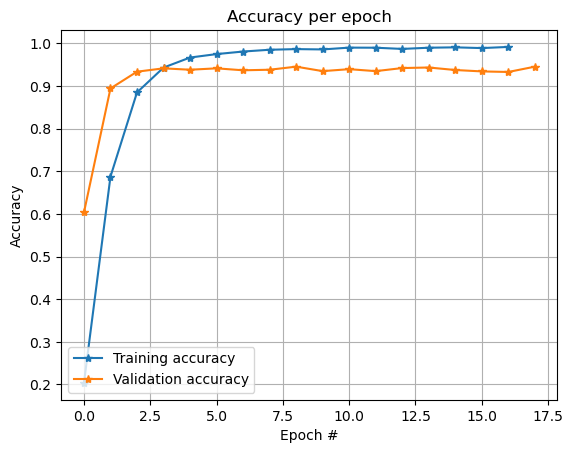

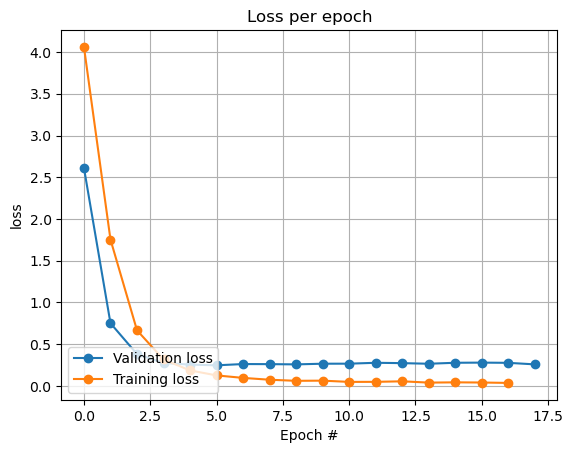

In [63]:
# accuracy 및  loss 시각화
plot_acc(history)
plt.figure()
plot_loss(history)